# Email Classification 

## Introduction

<img align="right" width="175" height="175" src="./figures/stressful.png"> Spam classification has been a widely studied NLP task. In our daily life, one's personal definition for spam emails could be very different. Like many others I have a Gmail account that I use for registration or subscription to websites or feeds. Over time it has accumulated tons of emails including ads and trivial updates that I would hardly skim over. However, buried under this mountain of emails are the actually IMPORTANT ones: personal messages from family and friends, important account records, tax document, medical bills, etc. I have a habit of archiving these emails for future references but over time I am growing tired of manually filtering out and classifying emails. Moreover, scanning through tens of emails each day, one could mistakenly delete important emails without even noticing. This makes me think, if I can build a automatic email filter based on the thousands of previously labeled or classified emails? Furthermore, this filter, if successful, would help me label future emails more consistently which in turn will improve the filter even further.

What features may be useful in email classification?
1. The subject and the text body are the most informative features in most situations. One could train a classification model directly based on the text, or extract additional features, e.g., BOW, TF-IDF, text length, number of punctuations, that could feed into a classifier.
2. Sender(From). Emails from personal accounts and several institutional accounts are more likely to be important than those from big companies. However, there are exceptions, for example, receipts, bills and tax documents should be kept, while trivial weekly updates from the University would normally be discard.
3. Recipients(To). Usually emails with 2 - 10 recipients are important, especially if some of the recipients are friends, collaborators, etc.

In this notebook I will focus on building a email filter using only the text information (#1 point). This includes training and comparing various classifiers from 6000+ emails from my personal Gmail account. I collected these emails using the Gmail APIs and pre-processed them with various NLP libraries (more details in ). Around 10% of the emails have been labeled as important, based on various criteria. To perform binary classification on these emails, I trained a SVC and a Naive Bayes classifier from the word vectors, as well as two neural networks, a BERT (Bidirectional Encoder Representations from Transformers) model and a BiLSTM (Bidirectional Long Short-Term Memory) model, based on the subjects of the emails.

To begin with, I split the email sample into training and test set (80%/20%). Since the dataset is very imbalanced for the binary classification task with less than 10% positive samples (important emails), I upsampled the positive samples so that the positive and negative samples are comparable. Finally I would apply the trained model on the test set to evaluate the precision/recall of the classifier.

Training on an imbalanced dataset may yield disastrous results. For example, in this email classification task, without up-sampling the BiLSTM model may tend to predict every single email as unimportant, i.e., >90% accuracy but 0% recall. My experiments also show that the SVC is quite robust to imbalanced dataset while the Naive Bayes classifier is not.



## Email Dataset

### Labeling

Using the Gmail API ([code](https://github.com/shuiyao/gmail_helper/blob/main/gmail.py)), I collected a total of 6000+ emails from my personal account. Firstly, I labeled all emails from my personal sub-folders as *important* and labeled the rest of the emails in the INBOX folder as *unimportant*. The reason is that I personally tend to manually categorize important emails and move them to a named sub-folder for keeping. However, this is by no means a very accurate way of labeling emails, as I sometimes forgot or simply was lazy to archive every single email that is considered important. For example, I used to keep every ATT bill in a separate folder but later discarded this habit. This could potentially confuse the classifier.

### Preprocessing

To make things easier, first I remove all emails that are composed in Chinese:

```python
from langdetect import DetectorFactory, detect
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 0

def is_eng(text):
    try:
        if detect(text) == 'zh-cn':
            return False
    except LangDetectException:
        return False
    return True

df = df[df['subject'].apply(is_eng)]
```

Next, I pre-processed the email body text. 
Some key steps specific to the email dataset are:
- Remove URLs. URLs are prevalent in emails, but the tokenizer often doesn't handle them well.
- Remove fragments of meaningless text. The email body text was converted from the html and often has uncleaned relics of html syntaxs. Therefore, I select only tokens that appear in one of the two NLTK corpus.

```python
import spacy
import string
from nltk import stopwords

def rm_punc_from_word(word):
    return ''.join([c for c in word if c not in string.punctuation])

stopwords_eng = stopwords.words('english')
stopwords_nopunc = set(map(rm_punc_from_word, stopwords.words('english')))

class SpacyLemmatizer():
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.postags = ["NOUN", "VERB", "ADJ", "ADV"]
    def lemmatize(self, words):
        doc = self.nlp(' '.join(words))
        return ' '.join([t.lemma_ for t in doc if t.pos_ in self.postags])

def clean_text(txt, lemmatizer=None, stemmer=None):
    '''
    Pre-process on the raw text: remove spurious features, remove punctuations and stop words, lemmatize.
    '''
    txt = txt.lower()
    txt = re.sub(r"https\S+", '', txt)

    txt = re.sub(r'([a-z])\1{2,}', r'\1', txt)
    txt = re.sub(r'([\W+])\1{1,}', r'\1', txt)

    chars = [c for c in txt if c not in string.punctuation]
    txt = ''.join(chars)
    words = [wd for wd in txt.split() if wd not in stopwords_nopunc]
    txt = ' '.join(words)
    if(stemmer is not None):
        words = [stemmer.stem() for wd in words]
    if(lemmatizer is not None):
        txt = lemmatizer.lemmatize(words)
    return txt

nltk_words = set(nltk.corpus.words.words())
web_words = set(nltk.corpus.webtext.words('firefox.txt'))

def remove_gibberish(txt):
    words = txt.split()
    words = [wd for wd in words if wd in nltk_words or wd in web_words]    
    txt = ' '.join(words)
    return txt
```

In the end I collected 5632 emails labeled unimportant and 434 emails labeled important, resulting in a very imbalanced dataset. I further separated these emails into a training set and a test set with a 80%/20% splitting.

The following code shows the number of positive/negative samples in the train/test set, and display a random sample from the training set.

In [4]:
import emailfilter
ef_svc = emailfilter.EmailFilterSVC()
ef_svc.load_data('train.csv', 'test.csv')

In [14]:
print(ef_svc.train['target'].value_counts())
print(ef_svc.test['target'].value_counts())

0    4502
1     351
Name: target, dtype: int64
0    1130
1      83
Name: target, dtype: int64


In [10]:
ef_svc.train.sample(n=5, random_state=15)

,subject,sender,labels,body,target
4106,Don't miss out on the final week of new online...,Tanglewood <mybso@bso.org>,"CATEGORY_PROMOTIONS, INBOX",experience new performance week musician world...,0
4042,⌛ Save up to 20% off Worldwide Car Rentals thi...,Webjet <noreply@webjet.com>,"CATEGORY_PROMOTIONS, IMPORTANT, INBOX",shuiyao save time money hassle worldwide car r...,0
1571,For your August 22 flight: Inflight Wi-Fi and ...,United Airlines <UnitedAirlines@news.united.com>,"CATEGORY_PROMOTIONS, IMPORTANT, INBOX",united airline unite mileageplus make next tra...,0
847,eTicket Itinerary and Receipt for Confirmation...,"""United Airlines, Inc. "" <unitedairlines@unite...","IMPORTANT, INBOX/TRAVEL, CATEGORY_UPDATES",eticket itinerary receipt receipt confirmation...,1
3154,A Special Message from Maestro Kevin Rhodes!,Springfield Symphony Orchestra <info@springfie...,"CATEGORY_PROMOTIONS, IMPORTANT, INBOX",dear friend sso hope join year meet musician e...,0


## Training

The classifiers are implemented in [emailfilter.py](https://github.com/shuiyao/gmail_helper/blob/main/emailfilter.py)

### Naive Bayes and Support Vector Classifiers

Both of these methods are known to have good performance in the spam classification task. Both classifiers train on a selected word vector representation of the text. Commonly used vectorization methods include the bag of words (BOW) and the term frequency - inverse document frequency (Tf-Idf). Here I will use the TfIdfVectorizer() from the sklearn library, though using the CountVectorizer() achieves a similar result for both classifiers.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(max_features=10000, max_df=0.9)

In [16]:
ef_svc = emailfilter.EmailFilterSVC(C=1.0, vectorizer=vectorizer)
ef_nb = emailfilter.EmailFilterBayes(alpha=1.0, vectorizer=vectorizer)

Both classifiers can be trained similarly as follows.

In [22]:
import pandas as pd
ef_svc.load_data('train.csv', 'test.csv')
ef_svc.vectorize() # Train the tfidf vectorizer
ef_svc.upsample() # Up-sample the minority class
ef_svc.fit()
_, _ = ef_svc.evaluate()

Precision: 0.48351648298514677
Recall: 0.5301204812890115
F1 score: 0.2528735379805811


In [23]:
ef_nb.load_data('train.csv', 'test.csv')
ef_nb.vectorize() # Train the tfidf vectorizer
ef_nb.upsample() # Up-sample the minority class
ef_nb.fit()
_, _ = ef_nb.evaluate()

Training samples after resampling: 9004
Precision: 0.3595505615957581
Recall: 0.7710843364203803
F1 score: 0.24521070609357068


### BiLSTM and BERT Classifiers

These methods rely on a trained neural network language model with a sigmoid layer attached at the end for binary classification. The BiLSTM used to be the architecture for state-of-art language models. One can initialize the weights in a BiLSTM model with pre-trained word embeddings (e.g., GloVe embeddings) to accelerate the training process. However, in recent years, the BERT model and its variants are often praised as revolutionary in the NLP field, so I decided to also train a BERT classifier to see how it performs on this small dataset.

In [18]:
ef_bilstm = emailfilter.EmailFilterBiLSTM()
ef_bert = emailfilter.EmailFilterBERT()

Training these models take much longer than the SVC or the Naive Bayes classifier. For the purpose of demonstration, I trained these models on the subject sentence instead of the entire email body.

```python
# User-defined Loss functions and Optimizers
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)
# metrics = ['accuracy'] 

# BiLSTM + GloVe embeddings
params_bilstm = {'epochs':20, 'batch_size':32, 'validation_steps':10}
ef_bilstm.load_data('train.csv','test.csv')
ef_bilstm.build_model()
ef_bilstm.upsample()
ef_bilstm.compile(loss=loss, optimizer=optimizer)
ef_bilstm.fit(**params_bilstm)
ef_bilstm.evaluate()

# BERT
params_bert = {'epochs':5, 'batch_size':32, 'validation_steps':10}
ef_bert.load_data('train.csv','test.csv')
ef_bert.upsample()
# efilter.load_model('model_bert_epoch5.h5') # optionally, one can load saved model
ef_bert.compile(loss=loss, optimizer=optimizer)
ef_bert.fit(**params_bert)
ef_bert.evaluate(return_false_samples=True)
```

I trained the BiLSTM model for 20 epochs and the BERT model for 5 epochs. The BERT model trains much slower but also converges much faster.

Log from the BiLSTM model:

```
Epoch 1/20
231/231 [==============================] - 14s 36ms/step - loss: 0.6881 - accuracy: 0.5941 - tp: 704.2543 - fn: 1171.5388 - preci: 0.6878 - recal: 0.3704 - val_loss: 0.6049 - val_accuracy: 0.7688 - val_tp: 104.0000 - val_fn: 56.0000 - val_preci: 0.8525 - val_recal: 0.6500
Epoch 2/20
231/231 [==============================] - 6s 25ms/step - loss: 0.5236 - accuracy: 0.8208 - tp: 1583.9526 - fn: 284.1638 - preci: 0.8197 - recal: 0.8207 - val_loss: 0.3206 - val_accuracy: 0.8781 - val_tp: 147.0000 - val_fn: 13.0000 - val_preci: 0.8497 - val_recal: 0.9187
...
Epoch 19/20
231/231 [==============================] - 6s 27ms/step - loss: 0.1350 - accuracy: 0.9442 - tp: 1819.2629 - fn: 46.4224 - preci: 0.9162 - recal: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9094 - val_tp: 148.0000 - val_fn: 6.0000 - val_preci: 0.8655 - val_recal: 0.9610
Epoch 20/20
231/231 [==============================] - 6s 26ms/step - loss: 0.1286 - accuracy: 0.9465 - tp: 1820.4052 - fn: 47.0948 - preci: 0.9207 - recal: 0.9765 - val_loss: 0.1842 - val_accuracy: 0.9281 - val_tp: 153.0000 - val_fn: 2.0000 - val_preci: 0.8793 - val_recal: 0.9871
```

Log from the BERT model

```
Epoch 1/5
231/231 [==============================] - 1326s 6s/step - loss: 0.3909 - accuracy: 0.8123 - tp: 1607.8664 - fn: 257.4655 - preci: 0.8104 - recal: 0.8131 - val_loss: 0.1316 - val_accuracy: 0.9469 - val_tp: 140.0000 - val_fn: 2.0000 - val_preci: 0.9032 - val_recal: 0.9859
Epoch 2/5
231/231 [==============================] - 1315s 6s/step - loss: 0.1026 - accuracy: 0.9647 - tp: 1817.7284 - fn: 51.1940 - preci: 0.9572 - recal: 0.9726 - val_loss: 0.1305 - val_accuracy: 0.9438 - val_tp: 152.0000 - val_fn: 6.0000 - val_preci: 0.9268 - val_recal: 0.9620
Epoch 3/5
231/231 [==============================] - 1314s 6s/step - loss: 0.0675 - accuracy: 0.9755 - tp: 1830.3534 - fn: 41.7414 - preci: 0.9730 - recal: 0.9782 - val_loss: 0.1001 - val_accuracy: 0.9719 - val_tp: 157.0000 - val_fn: 0.0000e+00 - val_preci: 0.9458 - val_recal: 1.0000
Epoch 4/5
231/231 [==============================] - 1325s 6s/step - loss: 0.0548 - accuracy: 0.9762 - tp: 1834.6638 - fn: 37.4741 - preci: 0.9730 - recal: 0.9796 - val_loss: 0.1244 - val_accuracy: 0.9500 - val_tp: 140.0000 - val_fn: 5.0000 - val_preci: 0.9272 - val_recal: 0.9655
Epoch 5/5
231/231 [==============================] - 1336s 6s/step - loss: 0.0644 - accuracy: 0.9733 - tp: 1833.1379 - fn: 42.1810 - preci: 0.9710 - recal: 0.9762 - val_loss: 0.0983 - val_accuracy: 0.9594 - val_tp: 141.0000 - val_fn: 8.0000 - val_preci: 0.9658 - val_recal: 0.9463
```

The test scores for the BiLSTM and the BERT classifers are:

BiLSTM:
```
Precision: 0.3540372668608464
Recall: 0.6867469871244013
F1 score: 0.23360653474032733
```

BERT:
```
Precision: 0.43902438988697207
Recall: 0.6506024088546959
F1 score: 0.2621358980181943
```

The ROC curves are also similar between these two models.

In [27]:
roc_bilstm = pd.read_csv('roc_bilstm_epoch20.csv')
roc_bert = pd.read_csv('roc_bert_epoch5.csv')

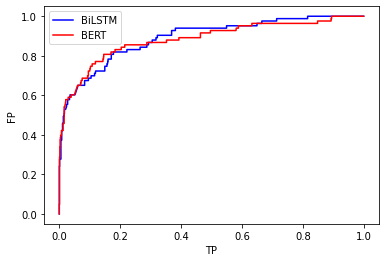

In [32]:
import matplotlib.pyplot as plt
plt.plot(roc_bilstm.FP, roc_bilstm.TP, "b-")
plt.plot(roc_bert.FP, roc_bert.TP, "r-")
plt.xlabel("TP")
plt.ylabel("FP")
plt.legend(['BiLSTM','BERT'])

Finally, take a look at the emails that are classified incorrectly:

In [33]:
bert_fp = pd.read_csv("bert_false_positive.csv")
bert_fn = pd.read_csv("bert_false_negative.csv")

First the "false positives" (incorrectly predicted as important).

In [41]:
bert_fp[['subject','target','pred']].iloc[1:10]

,subject,target,pred
1,Plymouth Rock policy PRA00002003913* Huang,0,0.982334
2,We approved your application,0,0.980728
3,Fwd: We've saved your application,0,0.997871
4,Fwd: by-law,0,0.949142
5,Your recent Dental Claim is ready for review,0,0.807456
6,Airport check-in required for confirmation P0E0WV,0,0.815866
7,Re: Make Schengen appointment [#1553],0,0.947283
8,Re: Make Schengen appointment [#1553],0,0.947283
9,Re: Make Schengen appointment [#1553],0,0.947283


Well, in fact some of them should be labeled as important emails so at least some of the mis-classifications are actually due to mis-labeling. Another finding is that the classifier indentifies many of the *replied* and *forwarded* emails as important, while I usually only keep the first email in the thread stored. Like the examples shown here, many of the false positives are not due to the machine learning algorithms.

Then the false negatives (important emails that are missed by the classifier):

In [42]:
bert_fn[['subject','target','pred']].iloc[1:10]

,subject,target,pred
1,Paperless enrollment confirmation,1,0.000126
2,Order ID: ORD20188453592606 From www.CallingCa...,1,0.338039
3,PO Number: ORD20188453592606 from www.CallingC...,1,0.088176
4,Your JetPens Order Has Shipped! (337681),1,0.000093
5,Your JetPens Order (337681),1,0.002366
6,NaN,1,0.000626
7,AT&T payment update,1,0.185311
8,WMECO E-Bill Ready For Viewing (72821705),1,0.415885
9,Stellar Physics,1,0.002143


Some of the misses here are also due to mis-labeling. For example, of the many emails with a subject like "Your ... Order ... Shipped", only a few is labeled as important. The labeling lacks consistency and therefore the classifier as well.

## Take-aways

I started out with 6000+ labeled emails from my personal Gmail account, hoping to train a binary classification model that automatically filter out important emails for me. I have used 4 different methods that are popular in spam classification applications, a Naive Bayes and a Support Vector classifier trained on Tf-Idf feature vectors from email bodies, and a BiLSTM and a BERT network trained on the email subjects. All four methods achieve similar precision/recall scores on a same test set, although the BERT model is significantly slower to train.

Upsampling the minority class (important emails) proves crucial to the Naive Bayes and the BiLSTM model. But the SVC and the BERT model are less sensitive to it.

The classifiers typically get a precision of 40% and a recall of 60%, a result that is much poorer than a typical spam classifier. However, there are several key areas of improvements:
1. **Inaccurate labels.** The labels of the email sample are inaccurate. For example, some emails, even though almost identical, are labeled inconsistently. I label an email as important or unimportant simply based on whether or not I have manually categorized it into a sub-folder, which I did before I started with the project. Therefore, it may worth re-labeling the emails in a more systematic and consistent way.
2. **Insufficient training data.** The sample size, 6000, is quite small especially for the neural network models. In fact both the BiLSTM and the BERT model had pretty good scores on the training data but do not fit the test data well. 
3. **Additional features.** The current model relies exclusively on the subject and body text, but one might come up with other features as described in the introduction.
4. **Preprocessing steps.** I have not got time to extensively try out different preprocessing methods.

Therefore, here are several actions considered for future works:
1. Explore the labeled Enron dataset (0.5 million emails) and:
  - Gain insights from these emails on extracting additional features that may be important
  - Manually select emails from different categories and label them for training
  - Improve pre-processing pipelines and fine tune the models with this much larger dataset
2. Train a higher level classifier leveraging additional features.
3. Deploy and integrate the classifier to guide email filtering for future incoming emails.


